# ProLiFIC EDA Notebook

Welcome to the **Exploratory Data Analysis (EDA)** notebook for the **ProLiFIC** dataset — *Procedural Lawmaking Flow in Italian Chambers*. This notebook walks you through:

- Loading and inspecting the event log and metadata
- Parsing timestamps and cleaning key fields
- Merging metadata with procedural event data
- Converting the dataset into a format suitable for **process mining** with `pm4py`
- Computing descriptive statistics and case durations
- Exploring temporal patterns and institutional trends in legislative processes

The ProLiFIC dataset covers Italian parliamentary activity from **1987 to 2022**, capturing detailed procedural traces for each legislative case. It is particularly suited for research in:

- **Legal process mining**
- **Governance and institutional modeling**
- **Temporal and policy analysis**

This EDA lays the foundation for more advanced questions about lawmaking duration, decree-law usage, legislative bottlenecks, and institutional dynamics.

## 📦 Requirements

This notebook requires the following Python libraries:

- `pandas` – for data manipulation
- `numpy` – for numerical operations
- `matplotlib` – for basic visualizations
- `pm4py` – for process mining functionalities

To install the missing libraries, run:

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=943b39963fe781b8ce009d1c6287d9c0a7ae73b6b99db3249fd22e1f470d5d75
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built intervaltree


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


## 📄 Load Data

We begin by loading the two main components of the ProLiFIC dataset:

- `ProLiFIC_event_log.csv`: procedural events (one row per event)
- `ProLiFIC_metadata.csv`: metadata per case (one row per law)

In [3]:
# Load event log and metadata
#If running on local files
#event_log = pd.read_csv('data/ProLiFIC_event_log.csv', index_col=False)
#metadata = pd.read_csv('data/ProLiFIC_metadata.csv', index_col=False)

#If running using remote files on github
github_path="https://github.com/matildeec/ProLiFIC/raw/refs/heads/main/"
event_log = pd.read_csv(github_path+'data/ProLiFIC_event_log.csv', index_col=False)
metadata = pd.read_csv(github_path+'data/ProLiFIC_metadata.csv', index_col=False)

In [4]:
event_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122361 entries, 0 to 122360
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   case_id      122361 non-null  object
 1   chamber      122361 non-null  object
 2   activity_it  122361 non-null  object
 3   activity_en  122361 non-null  object
 4   time         122361 non-null  object
 5   committee    98451 non-null   object
 6   person       6475 non-null    object
 7   chunk        122357 non-null  object
dtypes: object(8)
memory usage: 7.5+ MB


In [5]:
event_log

,case_id,chamber,activity_it,activity_en,time,committee,person,chunk
0,22G00184,senato,Presentazione,Presentation,2018-10-05-00-00,NaN,NaN,Senato della Repubblica (atto numero 865): Di ...
1,22G00184,senato,Assegnazione,Assignment,2018-11-06-00-00,COMMISSIONE 1,NaN,Assegnato alla 1 commissione permanente (Affar...
2,22G00184,senato,Esame in commissione,Committee examination,2020-02-11-00-00,COMMISSIONE 1,NaN,Esaminato dalla 1 commissione (Affari costituz...
3,22G00184,senato,Esame in commissione,Committee examination,2020-07-07-00-00,COMMISSIONE 1,NaN,Esaminato dalla 1 commissione (Affari costituz...
4,22G00184,senato,Esame in commissione,Committee examination,2020-07-21-00-00,COMMISSIONE 1,NaN,Esaminato dalla 1 commissione (Affari costituz...
...,...,...,...,...,...,...,...,...
122356,099G0082,camera,Richiesta parere,Request for opinion,1999-01-28-00-02,COMMISSIONE 2,NaN,"Assegnato alla VI commissione (Finanze), in se..."
122357,099G0082,camera,Richiesta parere,Request for opinion,1999-01-28-00-03,COMMISSIONE 5,NaN,"Assegnato alla VI commissione (Finanze), in se..."
122358,099G0082,camera,Richiesta parere,Request for opinion,1999-01-28-00-04,COMMISSIONE 11,NaN,"Assegnato alla VI commissione (Finanze), in se..."
122359,099G0082,camera,Esame in commissione,Committee examination,1999-02-03-00-00,COMMISSIONE 6,NaN,Esaminato dalla VI commissione e approvato il ...


In [7]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4395 entries, 0 to 4394
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   case_id              4395 non-null   object
 1   title                4395 non-null   object
 2   legislature          4395 non-null   object
 3   government           4395 non-null   object
 4   publishing_date      4395 non-null   object
 5   implementation_date  1497 non-null   object
 6   decree_conversion    4395 non-null   int64 
 7   eu_ratification      4395 non-null   int64 
 8   articles             4395 non-null   int64 
 9   description          4386 non-null   object
 10  full_text_url        4395 non-null   object
dtypes: int64(3), object(8)
memory usage: 377.8+ KB


In [8]:
metadata

,case_id,title,legislature,government,publishing_date,implementation_date,decree_conversion,eu_ratification,articles,description,full_text_url
0,22G00184,L. 2/2022,XVIII,Draghi,2022-11-15,2022-11-30,0,0,1,Modifica all''articolo 119 della Costituzione\...,https://www.gazzettaufficiale.it/eli/id/2022/1...
1,22G00152,L. 142/2022,XVIII,Draghi,2022-09-21,2022-09-22,1,0,1,"Conversione in legge\, con modificazioni\, del...",https://www.gazzettaufficiale.it/eli/id/2022/0...
2,22G00149,L. 140/2022,XVIII,Draghi,2022-09-15,2022-09-30,0,0,5,Disposizioni per la celebrazione dell''ottavo ...,https://www.gazzettaufficiale.it/eli/id/2022/0...
3,22G00139,L. 129/2022,XVIII,Draghi,2022-09-01,2022-09-16,0,0,1,Delega al Governo per il riordino della discip...,https://www.gazzettaufficiale.it/eli/id/2022/0...
4,22G00141,L. 130/2022,XVIII,Draghi,2022-09-01,2022-09-16,0,0,8,Disposizioni in materia di giustizia e di proc...,https://www.gazzettaufficiale.it/eli/id/2022/0...
...,...,...,...,...,...,...,...,...,...,...,...
4390,087U0401,L. 401/1987,X,Goria,1987-10-03,NaN,1,0,1,"Conversione in legge\, con modificazioni\, del...",https://www.gazzettaufficiale.it/eli/id/1987/1...
4391,087U0400,L. 400/1987,X,Goria,1987-10-03,NaN,1,0,1,"Conversione in legge\, con modificazioni\, del...",https://www.gazzettaufficiale.it/eli/id/1987/1...
4392,087U0399,L. 399/1987,X,Goria,1987-10-03,NaN,1,0,1,"Conversione in legge\, con modificazioni\, del...",https://www.gazzettaufficiale.it/eli/id/1987/1...
4393,087U0398,L. 398/1987,X,Goria,1987-10-03,NaN,1,0,1,"Conversione in legge\, con modificazioni\, del...",https://www.gazzettaufficiale.it/eli/id/1987/1...


### Format Timestamps

We convert the `time` column to datetime format. The original format includes year, month, day, hour, and minute.

In [9]:
# Convert the 'time' column from string to datetime, matching the format YYYY‑MM‑DD‑HH‑MM
event_log['time'] = pd.to_datetime(
    event_log['time'],
    format='%Y-%m-%d-%H-%M',
    errors='coerce')

### Merge Metadata

We enrich the event log with metadata fields such as:
- `decree_conversion`: Whether the law is a conversion of a decree-law
- `legislature`: The legislative term

In [10]:
# Choose columns to merge
cols = ['case_id', 'decree_conversion', 'legislature']

df = event_log.merge(
    metadata[cols],
    on='case_id',
    how='left'
)

# Optional: save the merged dataset for reuse
# df.to_csv('ProLiFIC_merged.csv', index=False)

## 📊 Dataset Overview

This overview uses the merged dataset, combining event log data with metadata. We report:

- The total number of unique legislative cases (`case_id`)
- The number of legislatures represented
- Counts of decree-law conversions
- The most common legislative activities (in English)

In [11]:
print("Dataset Overview (merged DataFrame)")

num_cases = df['case_id'].nunique()
num_legislatures = df['legislature'].nunique()
num_decrees = df['decree_conversion'].sum()
top_activities = df['activity_en'].value_counts().head()

print(f"- Number of unique legislative cases: {num_cases}")
print(f"- Number of legislatures covered: {num_legislatures}")
print(f"- Number of decree-law conversions: {num_decrees}")

print("\nTop 5 most common activity types:")
print(top_activities)

Dataset Overview (merged DataFrame)
- Number of unique legislative cases: 4395
- Number of legislatures covered: 9
- Number of decree-law conversions: 33817

Top 5 most common activity types:
activity_en
Request for opinion      49861
Committee examination    34143
Assignment               11844
Approval                 10100
Plenary debate            9986
Name: count, dtype: int64


## ⚙️ Process Mining Inquiries

This section details the key preprocessing and analysis steps to prepare the dataset for process mining with pm4py and to extract meaningful insights:

### Convert to pm4py Event Log
We transform the merged Pandas DataFrame into a pm4py Event Log format, specifying `case_id` as the case identifier, enabling process-oriented analysis.

In [12]:
# Ensure datetime compatibility
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Convert to Event Log format
parameters = {
    converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case_id'
}
log = converter.apply(df, variant=converter.Variants.TO_EVENT_LOG, parameters=parameters)

### Calculate Case Durations

For each case (i.e., trace), we compute the time span from the first to the last event. This gives us an estimate of how long the legislative process took.

In [13]:
durations = {}
for trace in log:
    start = trace[0]['time']
    end = trace[-1]['time']
    case_id = trace.attributes['concept:name']
    durations[case_id] = (end - start).total_seconds() / (60 * 60 * 24)  # in days

# Convert to DataFrame
dur_df = pd.DataFrame([
    {'case_id': cid, 'duration_days': dur}
    for cid, dur in durations.items()
])

### Merge Duration Data with Metadata

We combine the duration table with metadata and calculate summary statistics by legislature.

In [14]:
dur_df = dur_df.merge(metadata, on='case_id', how='left')

### Summary Statistics by Legislature

We now compute summary statistics on the duration of legislative processes, grouping cases by legislature. We distinguish between decree-laws and regular laws, calculating:

- Total number of laws per legislature
- Number and percentage of decree-laws
- Median duration of the process for all laws, decree-laws, and non-decrees

In [15]:
# Group by legislature and calculate relevant aggregates
summary = dur_df.groupby('legislature').agg(
    laws_total=('case_id', 'count'),
    decrees_count=('decree_conversion', lambda x: (x == 1).sum()),
    median_duration_total=('duration_days', 'median'),
    median_duration_0=('duration_days', lambda x: x[dur_df.loc[x.index, 'decree_conversion'] == 0].median()),
    median_duration_1=('duration_days', lambda x: x[dur_df.loc[x.index, 'decree_conversion'] == 1].median())
).reset_index()

# Add percentage of decrees
summary['%_decrees'] = summary['decrees_count'] / summary['laws_total'] * 100

# Replace NaNs (if any) with 0 before converting to int
for col in ['median_duration_total', 'median_duration_0', 'median_duration_1', '%_decrees']:
    summary[col] = np.ceil(summary[col].fillna(0)).astype(int)

# Optional: drop decrees_count if not needed
# summary = summary.drop(columns='decrees_count')

In [16]:
display(summary)

,legislature,laws_total,decrees_count,median_duration_total,median_duration_0,median_duration_1,%_decrees
0,X,1060,197,281,368,55,19
1,XI,303,114,145,271,55,38
2,XII,292,124,88,209,51,43
3,XIII,892,179,280,343,54,21
4,XIV,676,202,190,268,52,30
5,XV,110,31,129,214,51,29
6,XVI,385,114,115,161,54,30
7,XVII,371,84,287,377,54,23
8,XVIII,306,102,218,418,54,34


### Visualize Median Durations

We plot the median durations across legislatures to visually compare:
- All laws
- Decree conversions
- Non-decrees

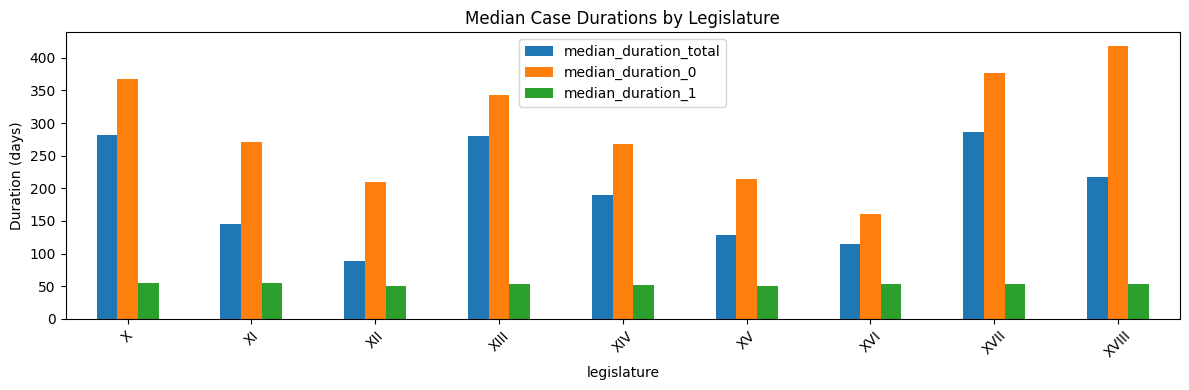

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
summary.set_index('legislature')[['median_duration_total', 'median_duration_0', 'median_duration_1']].plot(
    kind='bar', ax=ax
)
ax.set_title('Median Case Durations by Legislature')
ax.set_ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()